In [1]:
%matplotlib inline
import sys
sys.path.append('../common')
from plt_style import *
from sklearn.datasets import make_circles
import numpy,cupy
import pandas as pd, numpy as np, cudf
import os
import pylab as plt

In [2]:
x = numpy.random.random((10000, 10000))
y = cupy.random.random((10000, 10000))

In [3]:
%timeit bool((numpy.sin(x) ** 2 + numpy.cos(x) ** 2 == 1).all())
%timeit bool((cupy.sin(y) ** 2 + cupy.cos(y) ** 2 == 1).all())

2.15 s ± 7.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
105 ms ± 26.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
N   = int(1e6)
pdf = pd.DataFrame({'x': np.random.random(N),
                    'y': np.random.randint(0,100,size=N)})
gdf = cudf.DataFrame.from_pandas(pdf)

In [5]:
%timeit pdf.x.mean()
%timeit gdf.x.mean()

645 µs ± 789 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
134 µs ± 175 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
X, y = make_circles(n_samples=int(1e5), factor=.35, noise=.05)
X[:, 0] = 3*X[:, 0]
X[:, 1] = 3*X[:, 1]

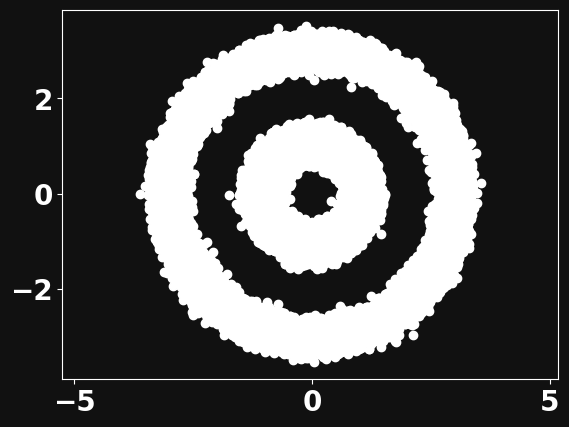

In [7]:
plt.scatter(*X.T,c='w')
_=plt.axis('equal')
_=plt.xticks(fontsize=20)
_=plt.yticks(fontsize=20)

### DBSCAN is a density-based clustering algorithm that can automatically classify groups of data, without the user having to specify how many groups there are.

In [8]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.6, min_samples=2)

In [9]:
%%time
y_db = db.fit_predict(X)

CPU times: user 4.94 s, sys: 1.48 s, total: 6.42 s
Wall time: 6.44 s


In [10]:
np.unique(y_db)

array([0, 1])

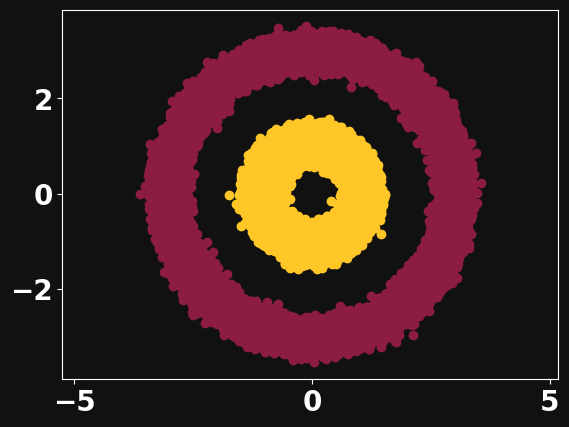

In [11]:
mask0,mask1 = y_db == 0, y_db==1
plt.scatter(*X[mask0].T,c=gld)
plt.scatter(*X[mask1].T,c=mrn)
_=plt.axis('equal')
_=plt.xticks(fontsize=20)
_=plt.yticks(fontsize=20)

In [12]:
X_df = pd.DataFrame({'fea%d'%i: X[:, i] for i in range(X.shape[1])})
X_gpu = cudf.DataFrame.from_pandas(X_df)

In [13]:
from cuml import DBSCAN as cumlDBSCAN
db_gpu = cumlDBSCAN(eps=0.6, min_samples=2)

In [14]:
%%time
y_db_gpu = db_gpu.fit_predict(X_gpu)

[W] [10:02:34.114720] Batch size limited by the chosen integer type (4 bytes). 100000 -> 21474. Using the larger integer type might result in better performance
CPU times: user 669 ms, sys: 25.3 ms, total: 694 ms
Wall time: 698 ms


In [15]:
cupy.unique(y_db_gpu)

array([0, 1], dtype=int32)

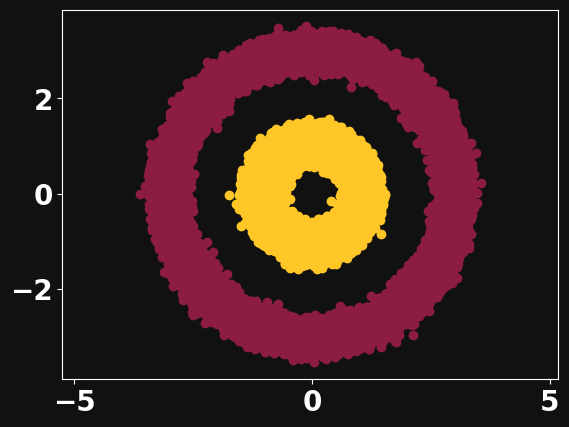

In [16]:
mask0,mask1 = y_db_gpu == 0, y_db_gpu==1
plt.scatter(*X_gpu[mask0].to_numpy().T,c=gld)
plt.scatter(*X_gpu[mask1].to_numpy().T,c=mrn)
_=plt.axis('equal')
_=plt.xticks(fontsize=20)
_=plt.yticks(fontsize=20)

![](speedup.png)

https://towardsdatascience.com/heres-how-you-can-accelerate-your-data-science-on-gpu-4ecf99db3430